In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install foolbox
import foolbox 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch.optim as optim
import math
import torch.utils.model_zoo as model_zoo

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Using cached foolbox-3.3.1.tar.gz (1.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python /usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmpfViszt
       cwd: /tmp/pip-install-t5WIRL/foolbox
  Complete output (18 lines):
  Traceback (most recent call last):
    File "/usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py", line 280, i

/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import argparse
import os
import numpy as np

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [3]:
torch.cuda.set_device('cuda:1')
torch.cuda.current_device()

1

In [4]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device1=torch.device('cpu')
print(device)

cuda


In [5]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.3681, 0.3813, 0.3448],[0.1505, 0.1406, 0.1377])
])

In [6]:
mean=[0.3681, 0.3813, 0.3448]
std=[0.1505, 0.1406, 0.1377]

def normalize(t):
    t[:, 0, :, :] = (t[:, 0, :, :] - mean[0])/std[0]
    t[:, 1, :, :] = (t[:, 1, :, :] - mean[1])/std[1]
    t[:, 2, :, :] = (t[:, 2, :, :] - mean[2])/std[2]

    return t

In [7]:
train_set=torchvision.datasets.ImageFolder(root='/home/ar_1/NWPU_train/', transform=transformer)
valid_set=torchvision.datasets.ImageFolder(root='/home/ar_1/NWPU_valid/', transform=transformer)

batch_size_train=4
batch_size_valid=4
train_loader=DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader=DataLoader(valid_set, batch_size_valid, shuffle=True)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=45):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model

In [9]:
model=resnet101().to(device)
model.load_state_dict(torch.load("/home/ar_1/weight/resnet101.pth"))
model=model.eval()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


###########################
# Generator: Resnet
###########################

# To control feature map in generator
ngf = 64

class GeneratorResnet(nn.Module):
    def __init__(self, inception=False, data_dim='high', eps=1.0, evaluate=False):
        '''
        :param inception: if True crop layer will be added to go from 3x300x300 t0 3x299x299.
        :param data_dim: for high dimentional dataset (imagenet) 6 resblocks will be add otherwise only 2.
        '''
        super(GeneratorResnet, self).__init__()
        self.inception = inception
        self.data_dim = data_dim
        # Input_size = 3, n, n
        self.block1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, ngf, kernel_size=7, padding=0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )

        # Input size = 3, n, n
        self.block2 = nn.Sequential(
            nn.Conv2d(ngf, ngf * 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )

        # Input size = 3, n/2, n/2
        self.block3 = nn.Sequential(
            nn.Conv2d(ngf * 2, ngf * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )

        # Input size = 3, n/4, n/4
        # Residual Blocks: 6
        self.resblock1 = ResidualBlock(ngf * 4)
        self.resblock2 = ResidualBlock(ngf * 4)
        if self.data_dim == 'high':
            self.resblock3 = ResidualBlock(ngf * 4)
            self.resblock4 = ResidualBlock(ngf * 4)
            self.resblock5 = ResidualBlock(ngf * 4)
            self.resblock6 = ResidualBlock(ngf * 4)
            

        # Input size = 3, n/4, n/4
        self.upsampl_inf1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )

        # Input size = 3, n/2, n/2
        self.upsampl_inf2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )

        # Input size = 3, n, n
        self.blockf_inf = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, 3, kernel_size=7, padding=0)
        )
        
        # Input size = 3, n/4, n/4
        self.upsampl_01 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True)
        )

        # Input size = 3, n/2, n/2
        self.upsampl_02 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True)
        )

        # Input size = 3, n, n
        self.blockf_0 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, 1, kernel_size=7, padding=0)
        )

        self.crop = nn.ConstantPad2d((0, -1, -1, 0), 0)
        
        self.eps = eps
        self.evaluate = evaluate

    def forward(self, input):
        x = self.block1(input)
        x = self.block2(x)
        x = self.block3(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        if self.data_dim == 'high':
            x = self.resblock3(x)
            x = self.resblock4(x)
            x = self.resblock5(x)
            x = self.resblock6(x)
        code = x
        x = self.upsampl_inf1(code)
        x = self.upsampl_inf2(x)
        x = self.blockf_inf(x)
        if self.inception:
            x = self.crop(x)
        x_inf = self.eps * torch.tanh(x) # Output range [-eps, eps]
        x = self.upsampl_01(code)
        x = self.upsampl_02(x)
        x = self.blockf_0(x)
        if self.inception:
            x = self.crop(x)
        x = (torch.tanh(x) + 1) / 2
        if self.evaluate:
            x_0 = torch.where(x<0.5, torch.zeros_like(x).detach(), torch.ones_like(x).detach())
        else:
            x_0 = torch.where(torch.rand(x.shape).cuda()<0.5, x, torch.where(x<0.5, torch.zeros_like(x), torch.ones_like(x)).detach())
        x_out = torch.clamp(x_inf * x_0 + input, min=0, max=1)
        return x_out, x_inf, x_0, x


class ResidualBlock(nn.Module):
    def __init__(self, num_filters):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, stride=1, padding=0,
                      bias=False),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(True),

            nn.Dropout(0.5),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, stride=1, padding=0,
                      bias=False),
            nn.BatchNorm2d(num_filters)
        )

    def forward(self, x):
        residual = self.block(x)
        return x + residual

In [11]:
netG= GeneratorResnet()
netG.to(device)

GeneratorResnet(
  (block1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (resblock1): ResidualBlock(
    (block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [12]:
optimG = optim.Adam(netG.parameters(), lr=0.001, betas=(0.5, 0.999))

In [13]:
def CWLoss(logits, target, kappa=-0., tar=False):
    
    target = torch.ones(logits.size(0)).type(torch.cuda.FloatTensor).mul(target.float())
    target_one_hot = Variable(torch.eye(45).type(torch.cuda.FloatTensor)[target.long()].cuda())
  
    
    real = torch.sum(target_one_hot*logits, 1)
    other = torch.max((1-target_one_hot)*logits - (target_one_hot*45), 1)[0]
    kappa = torch.zeros_like(other).fill_(kappa)
    
    if tar:
        return torch.sum(torch.max(other-real, kappa))
    else :
        return torch.sum(torch.max(real-other, kappa))
        
criterion = CWLoss

In [14]:
train_count=len(train_set)
valid_count=len(valid_set)

In [ ]:
lam_spa = 0.0001
lam_qua = 0.0001
num_epochs=100
for epoch in range(num_epochs):
    
    print("epoch: ",epoch)
    running_loss = 0
    for i, (img, gt) in enumerate(train_loader):
        img = img.to(device)
        gt = gt.to(device)

        label = model(normalize(img.clone().detach())).argmax(dim=-1).detach()
        
        netG.train()
        optimG.zero_grad()

        adv, adv_inf, adv_0, adv_00 = netG(img)
        adv_img = adv.clone()
        
        adv_out = model(normalize(adv))
        loss_adv = criterion(adv_out, label)
        

        loss_spa = torch.norm(adv_0, 1)
        bi_adv_00 = torch.where(adv_00<0.5, torch.zeros_like(adv_00), torch.ones_like(adv_00))
        loss_qua = torch.sum((bi_adv_00 - adv_00)**2)
        loss = loss_adv + lam_spa * loss_spa + lam_qua * loss_qua
        
        loss.backward()
        optimG.step()
    
    torch.save(netG.state_dict(), "/home/ar_1/generator/resnet101.pth")
 

In [15]:
netG = GeneratorResnet(eps=0.0005, evaluate=True)
netG.load_state_dict(torch.load("/home/ar_1/generator/resnet101.pth"))
netG.to(device)
netG.eval()

GeneratorResnet(
  (block1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (resblock1): ResidualBlock(
    (block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
dir='/home/ar_1/NWPU_train/'
classes = os.listdir(dir)
classes.sort()

L0 norm: tensor(0., device='cuda:2')
time: 0.0005684869657070724
Clean:41.510%	 Adversarial :17.758%	 Fooling Rate:75.517%
Robust Accuracy:  0.2448330683624801


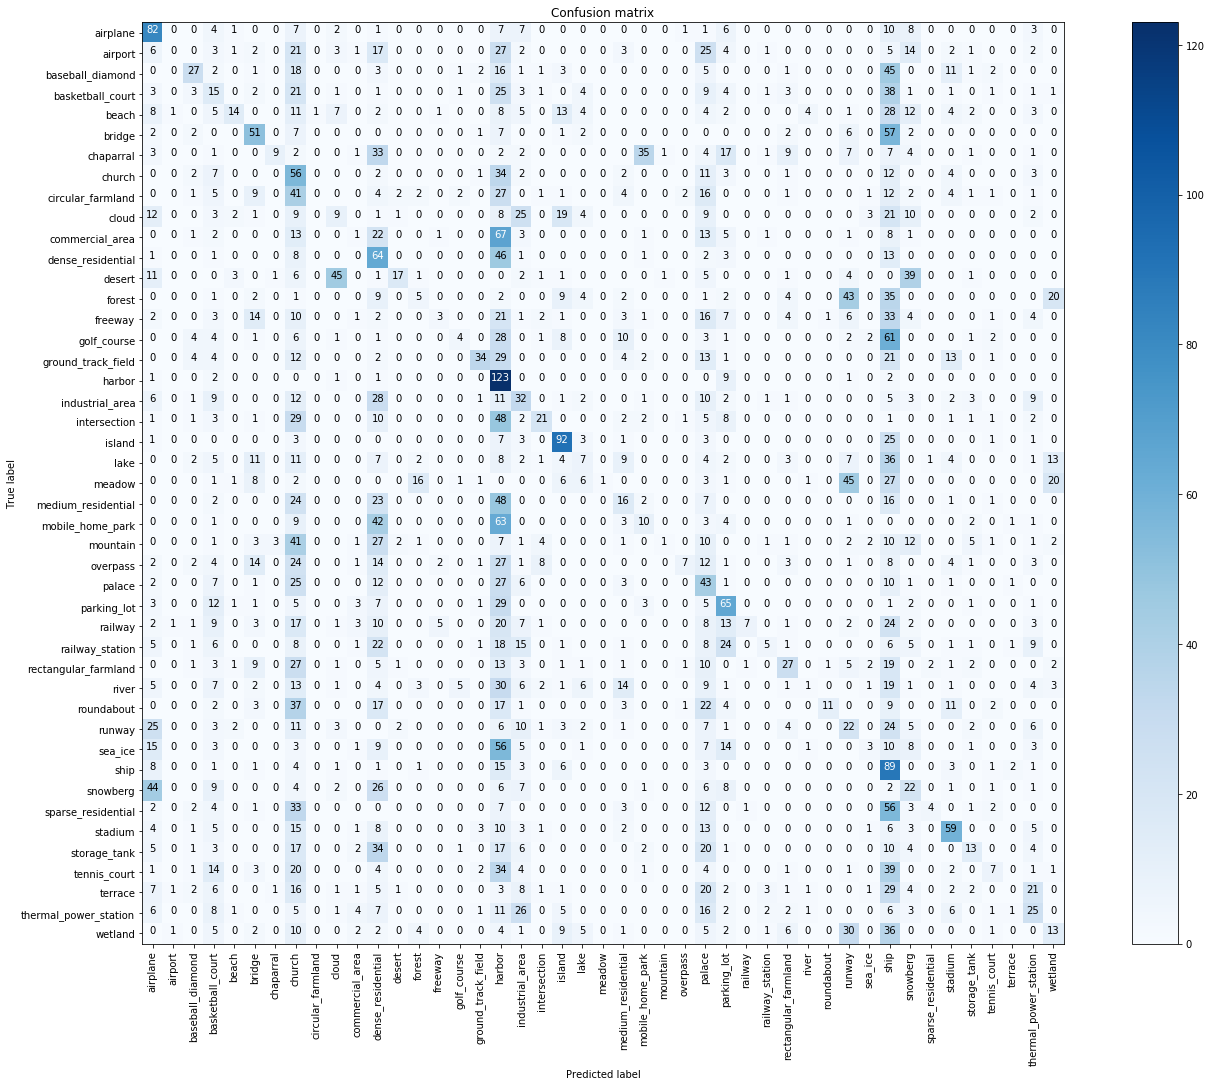

In [18]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 45) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_t=AlexNet().to(device)
model_t.load_state_dict(torch.load("/home/ar_1/weight/alexnet.pth"))
model_t=model_t.eval()



import time

# Evaluation
adv_acc = 0
clean_acc = 0
fool_rate = 0
target_rate = 0
norm = 0
time_count = 0

import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')


for i, (img, label) in enumerate(valid_loader):
    img, label = img.to(device), label.to(device)

    clean_out = model_t(normalize(img.clone().detach()))
    clean_acc += torch.sum(clean_out.argmax(dim=-1) == label).item()
    #print(clean_out.argmax(dim=-1))

    # Adversary
    start = time.time()
    adv,_,adv_0,adv_00 = netG(img)
    end = time.time()
    times = end - start
    time_count += times

    adv_out = model_t(normalize(adv.clone().detach()))   
    adv_acc +=torch.sum(adv_out.argmax(dim=-1) == label).item()
     
    fool_rate += torch.sum(adv_out.argmax(dim=-1) != clean_out.argmax(dim=-1)).item()
    #print(adv_out.argmax(dim=-1))
    
    norm += torch.norm(adv_0.clone().detach(), 0)

    _, preds = torch.max(adv_out, 1)
    labels_cat=torch.cat((labels_cat,label)) 
    preds_cat=torch.cat((preds_cat,preds))
   

test_size=valid_count
print('L0 norm:', norm/test_size)
print('time:', time_count/test_size)
print('Clean:{0:.3%}\t Adversarial :{1:.3%}\t Fooling Rate:{2:.3%}'.format(clean_acc/test_size, adv_acc/test_size, fool_rate/test_size))
print("Robust Accuracy: ",1-fool_rate/test_size )

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 
plt.figure(figsize=(20,15))
plot_confusion_matrix(cm, classes)

L0 norm: tensor(0., device='cuda:2')
time: 0.0012838273435025601
Clean:3.243%	 Adversarial :8.426%	 Fooling Rate:90.700%
Robust Accuracy:  0.09300476947535774


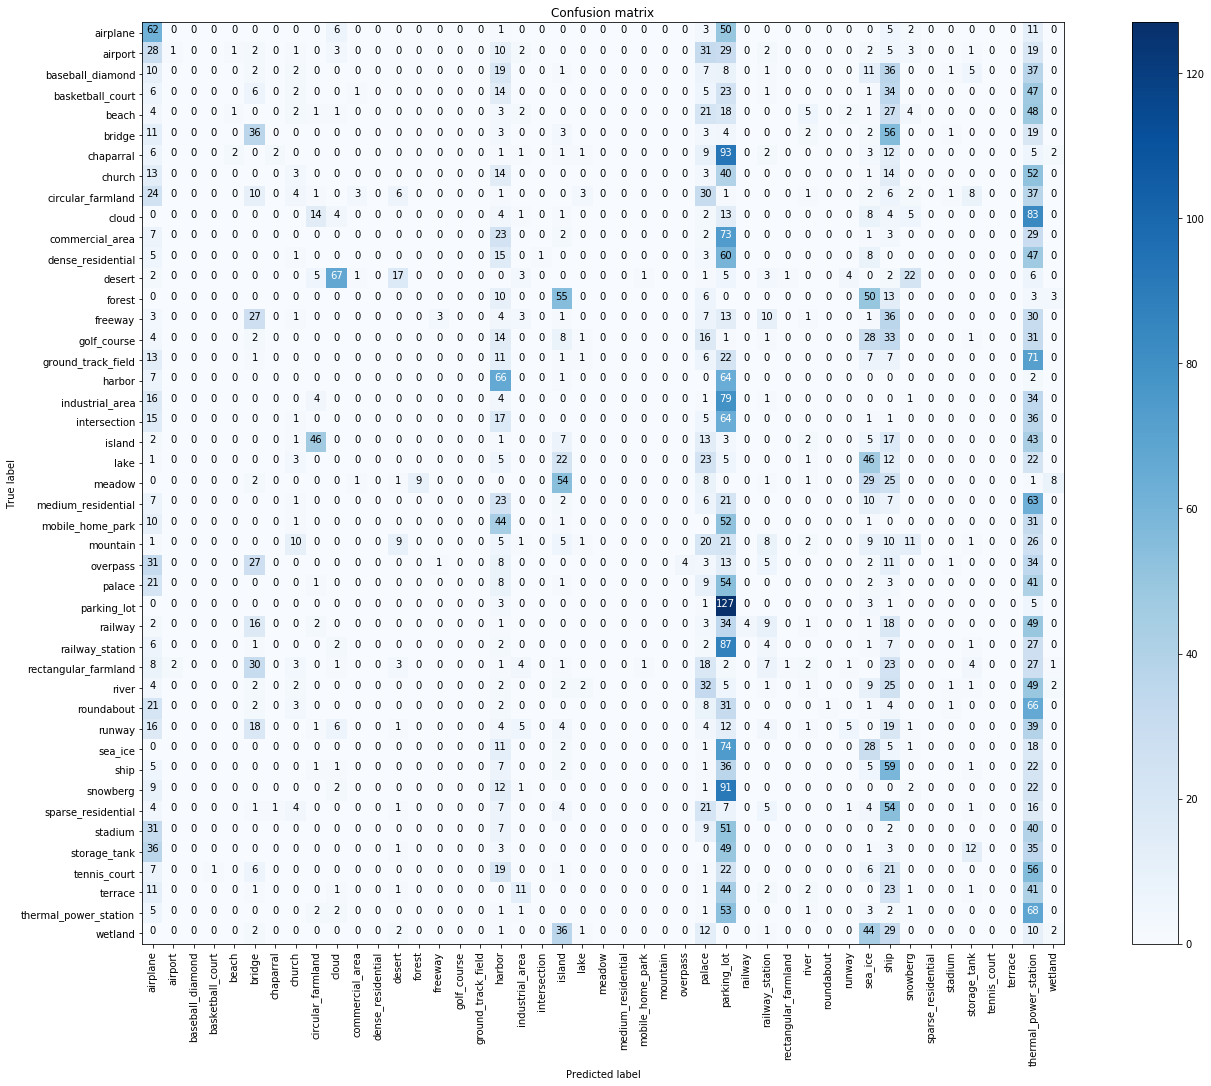

In [18]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=45):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

model_t=resnet50().to(device)
model_t.load_state_dict(torch.load("/home/ar_1/weight/resnet50.pth"))
model_t=model_t.eval()


import time

# Evaluation
adv_acc = 0
clean_acc = 0
fool_rate = 0
target_rate = 0
norm = 0
time_count = 0

import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')


for i, (img, label) in enumerate(valid_loader):
    img, label = img.to(device), label.to(device)

    clean_out = model_t(normalize(img.clone().detach()))
    clean_acc += torch.sum(clean_out.argmax(dim=-1) == label).item()
    #print(clean_out.argmax(dim=-1))

    # Adversary
    start = time.time()
    adv,_,adv_0,adv_00 = netG(img)
    end = time.time()
    times = end - start
    time_count += times

    adv_out = model_t(normalize(adv.clone().detach()))   
    adv_acc +=torch.sum(adv_out.argmax(dim=-1) == label).item()
     
    fool_rate += torch.sum(adv_out.argmax(dim=-1) != clean_out.argmax(dim=-1)).item()
    #print(adv_out.argmax(dim=-1))
    
    norm += torch.norm(adv_0.clone().detach(), 0)

    _, preds = torch.max(adv_out, 1)
    labels_cat=torch.cat((labels_cat,label)) 
    preds_cat=torch.cat((preds_cat,preds))
      
    
test_size=valid_count 
print('L0 norm:', norm/test_size)
print('time:', time_count/test_size)
print('Clean:{0:.3%}\t Adversarial :{1:.3%}\t Fooling Rate:{2:.3%}'.format(clean_acc/test_size, adv_acc/test_size, fool_rate/test_size))
print("Robust Accuracy: ",1-fool_rate/test_size )

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 
plt.figure(figsize=(20,15))
plot_confusion_matrix(cm, classes)

L0 norm: tensor(0., device='cuda:2')
time: 0.0011695464578455697
Clean:4.658%	 Adversarial :10.859%	 Fooling Rate:90.477%
Robust Accuracy:  0.09523052464228932


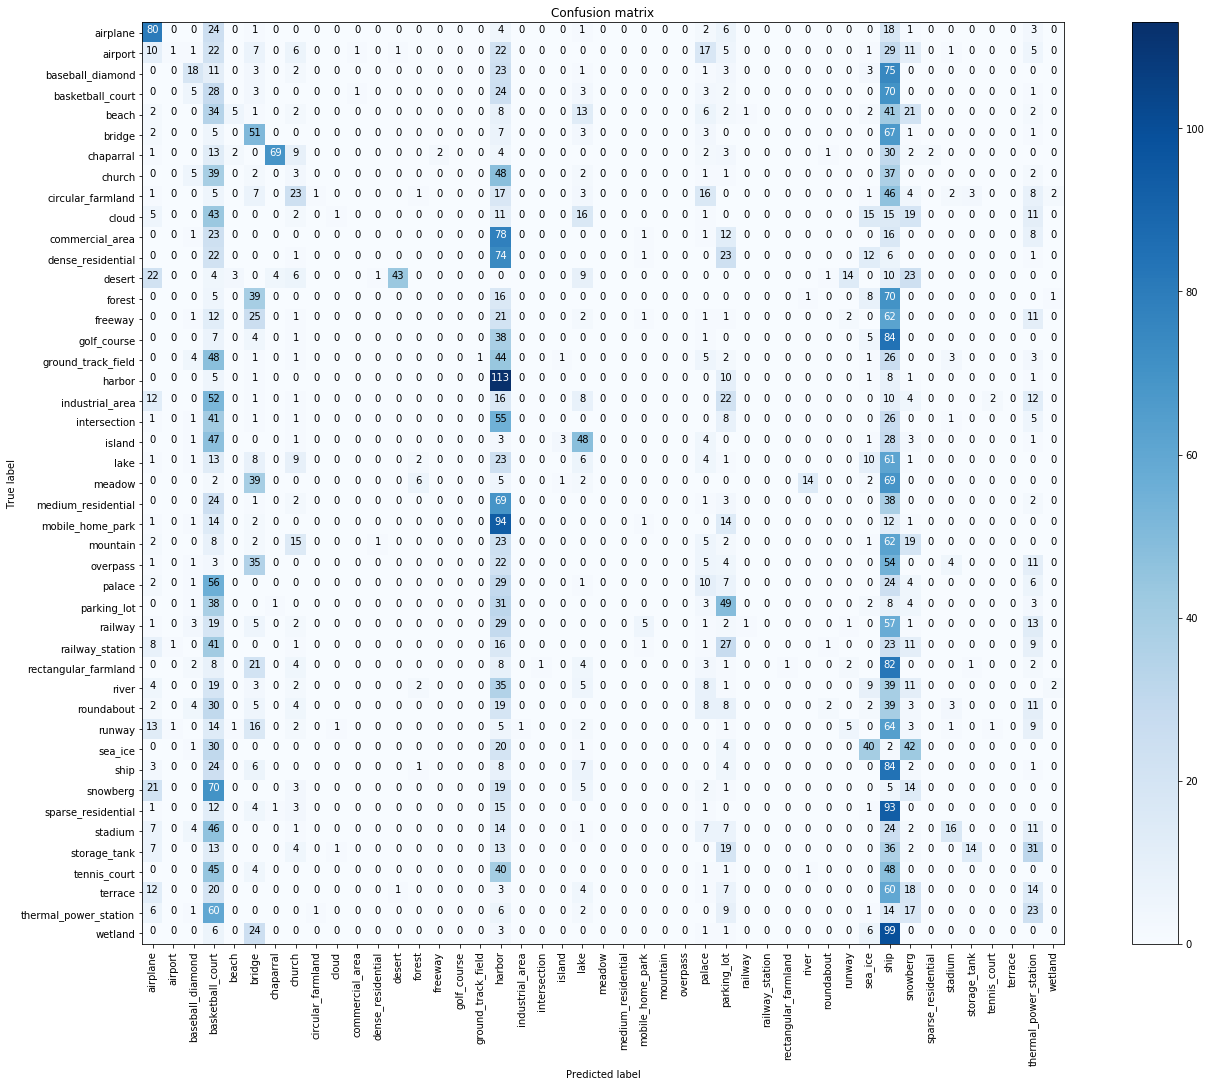

In [19]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=45):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model

model_t=resnet101().to(device)
model_t.load_state_dict(torch.load("/home/ar_1/weight/resnet101.pth"))
model_t=model_t.eval()


import time

# Evaluation
adv_acc = 0
clean_acc = 0
fool_rate = 0
target_rate = 0
norm = 0
time_count = 0

import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')


for i, (img, label) in enumerate(valid_loader):
    img, label = img.to(device), label.to(device)

    clean_out = model_t(normalize(img.clone().detach()))
    clean_acc += torch.sum(clean_out.argmax(dim=-1) == label).item()
    #print(clean_out.argmax(dim=-1))

    # Adversary
    start = time.time()
    adv,_,adv_0,adv_00 = netG(img)
    end = time.time()
    times = end - start
    time_count += times

    adv_out = model_t(normalize(adv.clone().detach()))   
    adv_acc +=torch.sum(adv_out.argmax(dim=-1) == label).item()
     
    fool_rate += torch.sum(adv_out.argmax(dim=-1) != clean_out.argmax(dim=-1)).item()
    #print(adv_out.argmax(dim=-1))
    
    norm += torch.norm(adv_0.clone().detach(), 0)

    _, preds = torch.max(adv_out, 1)
    labels_cat=torch.cat((labels_cat,label)) 
    preds_cat=torch.cat((preds_cat,preds))
      


test_size=valid_count  
print('L0 norm:', norm/test_size)
print('time:', time_count/test_size)
print('Clean:{0:.3%}\t Adversarial :{1:.3%}\t Fooling Rate:{2:.3%}'.format(clean_acc/test_size, adv_acc/test_size, fool_rate/test_size))
print("Robust Accuracy: ",1-fool_rate/test_size )

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 
plt.figure(figsize=(20,15))
plot_confusion_matrix(cm, classes)

L0 norm: tensor(0., device='cuda:1')
time: 0.001401777714727793
Clean:10.238%	 Adversarial :12.544%	 Fooling Rate:65.803%
Robust Accuracy:  0.3419713831478537


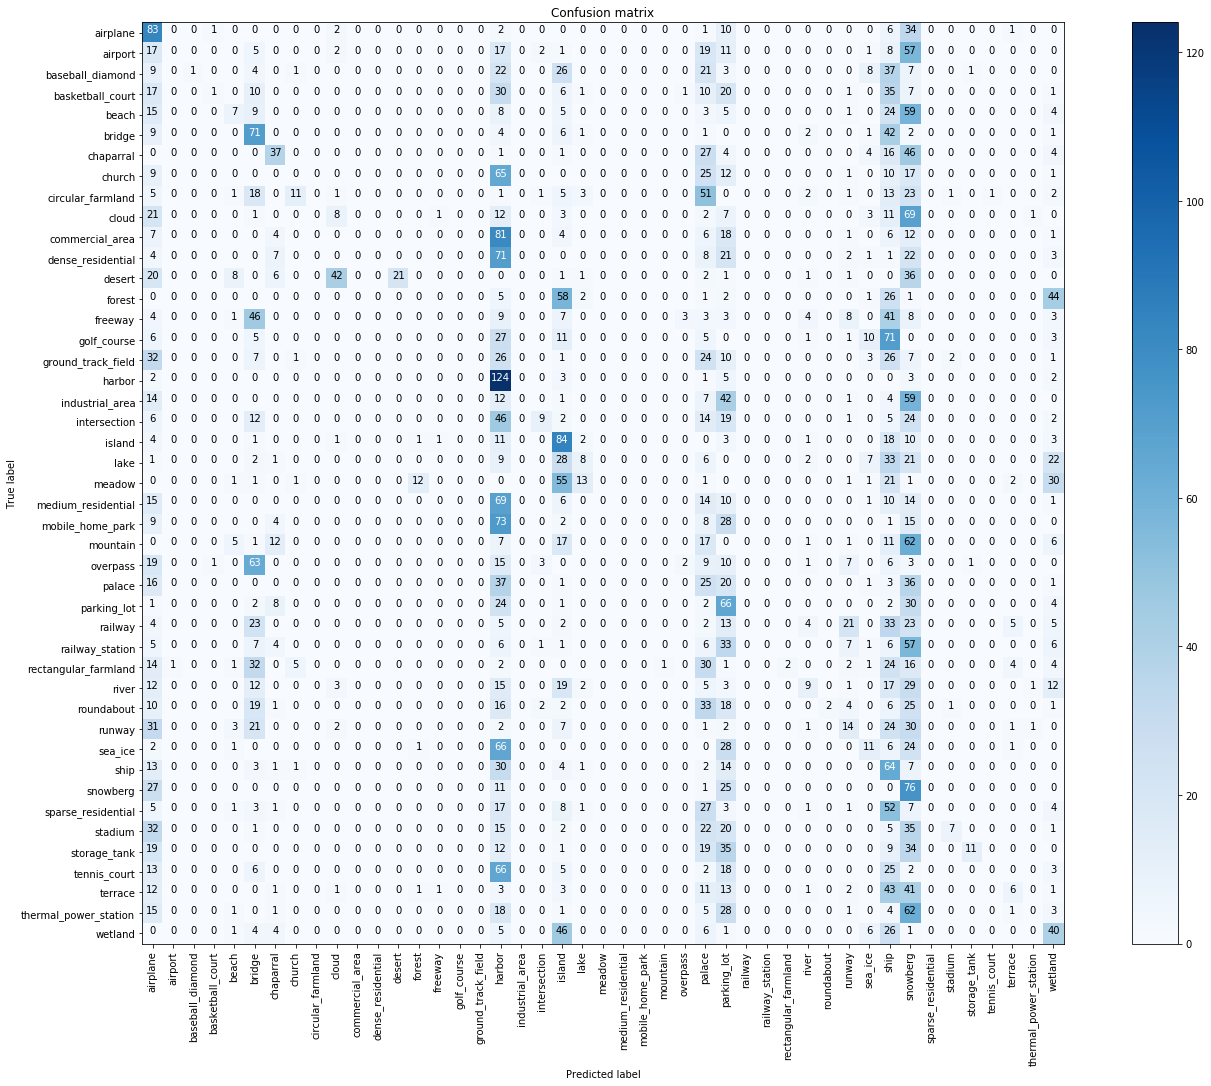

In [18]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=45, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

model_t=MobileNetV2().to(device)
model_t.load_state_dict(torch.load("/home/ar_1/weight/mobilenet.pth"))
model_t=model_t.eval()



import time

# Evaluation
adv_acc = 0
clean_acc = 0
fool_rate = 0
target_rate = 0
norm = 0
time_count = 0

import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')


for i, (img, label) in enumerate(valid_loader):
    img, label = img.to(device), label.to(device)

    clean_out = model_t(normalize(img.clone().detach()))
    clean_acc += torch.sum(clean_out.argmax(dim=-1) == label).item()
    #print(clean_out.argmax(dim=-1))

    # Adversary
    start = time.time()
    adv,_,adv_0,adv_00 = netG(img)
    end = time.time()
    times = end - start
    time_count += times

    adv_out = model_t(normalize(adv.clone().detach()))   
    adv_acc +=torch.sum(adv_out.argmax(dim=-1) == label).item()
     
    fool_rate += torch.sum(adv_out.argmax(dim=-1) != clean_out.argmax(dim=-1)).item()
    #print(adv_out.argmax(dim=-1))
    
    norm += torch.norm(adv_0.clone().detach(), 0)

    _, preds = torch.max(adv_out, 1)
    labels_cat=torch.cat((labels_cat,label)) 
    preds_cat=torch.cat((preds_cat,preds))
      
   

test_size=valid_count  
print('L0 norm:', norm/test_size)
print('time:', time_count/test_size)
print('Clean:{0:.3%}\t Adversarial :{1:.3%}\t Fooling Rate:{2:.3%}'.format(clean_acc/test_size, adv_acc/test_size, fool_rate/test_size))
print("Robust Accuracy: ",1-fool_rate/test_size )

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 
plt.figure(figsize=(20,15))
plot_confusion_matrix(cm, classes)

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Using cached foolbox-3.3.1.tar.gz (1.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python /usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmp4GYs5b
       cwd: /tmp/pip-install-JdvkgG/foolbox
  Complete output (18 lines):
  Traceback (most recent call last):
    File "/usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py", line 280, i

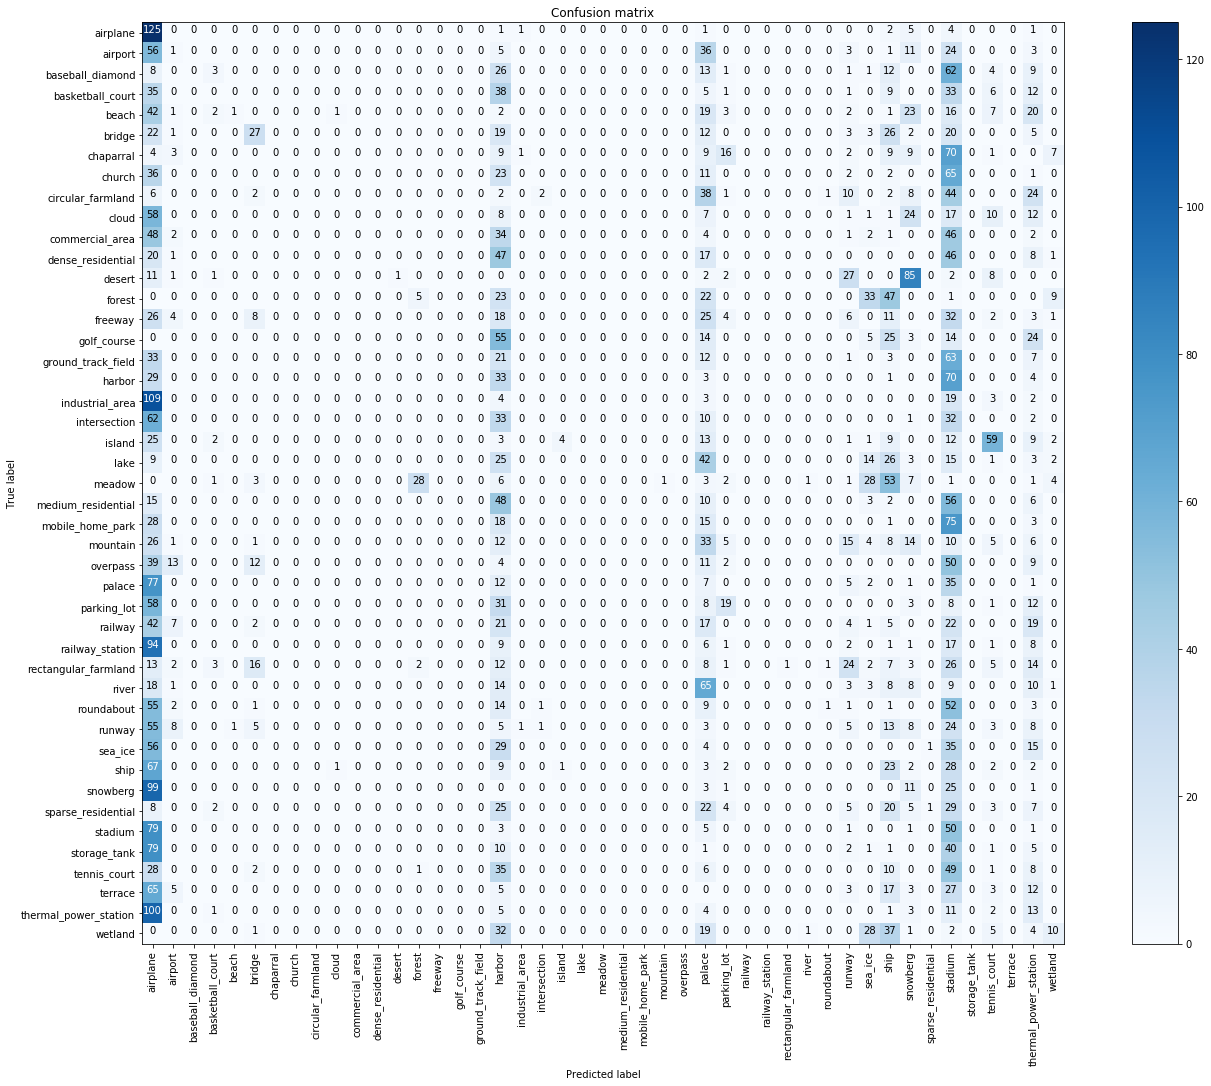

In [19]:
!pip install foolbox
import foolbox 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch.optim as optim
import math
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple

class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 45,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model

def densenet121(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)
    
model_t=densenet121().to(device)
model_t.load_state_dict(torch.load("/home/ar_1/weight/densenet.pth"))
model_t=model_t.eval()


import time

# Evaluation
adv_acc = 0
clean_acc = 0
fool_rate = 0
target_rate = 0
norm = 0
time_count = 0

import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')


for i, (img, label) in enumerate(valid_loader):
    img, label = img.to(device), label.to(device)

    clean_out = model_t(normalize(img.clone().detach()))
    clean_acc += torch.sum(clean_out.argmax(dim=-1) == label).item()
    #print(clean_out.argmax(dim=-1))

    # Adversary
    start = time.time()
    adv,_,adv_0,adv_00 = netG(img)
    end = time.time()
    times = end - start
    time_count += times

    adv_out = model_t(normalize(adv.clone().detach()))   
    adv_acc +=torch.sum(adv_out.argmax(dim=-1) == label).item()
     
    fool_rate += torch.sum(adv_out.argmax(dim=-1) != clean_out.argmax(dim=-1)).item()
    #print(adv_out.argmax(dim=-1))
    
    norm += torch.norm(adv_0.clone().detach(), 0)

    _, preds = torch.max(adv_out, 1)
    labels_cat=torch.cat((labels_cat,label)) 
    preds_cat=torch.cat((preds_cat,preds))
      
    

test_size=valid_count
print('L0 norm:', norm/test_size)
print('time:', time_count/test_size)
print('Clean:{0:.3%}\t Adversarial :{1:.3%}\t Fooling Rate:{2:.3%}'.format(clean_acc/test_size, adv_acc/test_size, fool_rate/test_size))
print("Robust Accuracy: ",1-fool_rate/test_size )

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 
plt.figure(figsize=(20,15))
plot_confusion_matrix(cm, classes)